In [1]:
import os
import sys
import random

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from PIL import Image
from torchvision import models, transforms
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error

import tensorboard

sys.path.append('/home/jko/ice3d')
from models.mlp_regression import MLPRegression
from models.mlp_classification import MLPClassification
from models.resnet18_regression import ResNet18Regression
from models.resnet18_classification import ResNet18Classification

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from data.tabular_datamodule import TabularDataModule
from data.tabular_dataset import TabularDataset
from data.single_view_datamodule import SingleViewDataModule
from data.single_view_dataset import SingleViewDataset
from data.stereo_view_datamodule import StereoViewDataModule
from data.stereo_view_dataset import StereoViewDataset
import json
from torchvision.models import ResNet18_Weights

import shap

Run SHAP using trained MLP

# SHAP for Regression

In [15]:
# tabular
tab_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
tab_file = 'ros-tabular-data-shuffled-default-subset-700000.parquet'
tab_path = os.path.join(tab_dir, tab_file)
tab_stereo_2ds_file = 'ros-tabular-data-stereo-default-2ds-shuffled-subset-700000.parquet'
tab_stereo_2ds_path = os.path.join(tab_dir, tab_stereo_2ds_file)
tab_stereo_phips_file = 'ros-tabular-data-stereo-default-phips-shuffled-subset-700000.parquet'
tab_stereo_phips_path = os.path.join(tab_dir, tab_stereo_phips_file)
# Load the class mapping from a JSON file
class_mapping_file = '/home/jko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

In [16]:
features = ['aspect_ratio', 'aspect_ratio_elip', 
'extreme_pts', 'contour_area', 'contour_perimeter', 
'area_ratio', 'complexity', 'circularity']
targets = ['rho_eff', 'sa_eff']
batch_size = 128
n_rand = 666
num_workers = 16
def log_transform(x):
    return torch.log(x)
split = [0.7, 0.15, 0.15]
n_data = 700_000
assert abs(sum(split) - 1.0) < 1e-8, "Split does not sum to 1"
n_train = int(split[0] * n_data)
n_val = int(split[1] * n_data)
n_test = n_data - n_train - n_val  # ensures all data is used
train_idx = list(range(0, n_train))
val_idx = list(range(n_train, n_train + n_val))
test_idx = list(range(n_train + n_val, n_data))

In [17]:
def get_transforms(data_type, input_channels, task_type):
    transforms = {}
    # Define transforms based on data_type
    if data_type in ['single_view_h5', 'stereo_view_h5']:
        train_transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        val_transform = T.Compose([
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        transforms['train'] = train_transform
        transforms['val'] = val_transform
        transforms['test'] = val_transform
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['train_target'] = target_transform
        transforms['val_target'] = target_transform
        transforms['test_target'] = target_transform    
        return transforms
    elif data_type == 'tabular':
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['target'] = target_transform
        return transforms
    else:
        return None

# user parameters        
data_type = 'tabular'
input_channels = 2
task_type = 'regression'
transforms = get_transforms(data_type, input_channels, task_type)

In [18]:
# set up tabular data module
dm = TabularDataModule(
    data_file=tab_path,
    feature_names=features,
    target_names=targets,
    batch_size=batch_size,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=num_workers,
    task_type='regression',
    class_to_idx=None,
    target_transform=transforms['target'],
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()

In [19]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/mlp-regression-subset-700k-csv/version_1/checkpoints/model-epoch=46-val_loss=0.0142.ckpt'
model = MLPRegression.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_size=8, 
    output_size=2, 
    learning_rate=1e-3
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model.to("cpu")

model.eval()

MLPRegression(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

In [20]:
# Collect at least N samples (e.g., 250)
loader = dm.test_dataloader()
inputs_list = []
N = 1000
for batch in loader:
    # If batch is (inputs, targets)
    if isinstance(batch, (tuple, list)):
        inputs = batch[0]
    else:
        inputs = batch
    inputs_list.append(inputs)
    if sum(x.shape[0] for x in inputs_list) >= N:
        break

# Concatenate and trim to exactly N samples
all_inputs = torch.cat(inputs_list, dim=0)[:N]

background = all_inputs[:100]
test_samples = all_inputs[100:600]

In [21]:
# Ensure tensors are on the same device as the model
background = background.to(model.device)
test_samples = test_samples.to(model.device)

# explainer = shap.DeepExplainer(model, background)
# NOTE: deepexplainer doesn't work for some reason
explainer = shap.GradientExplainer(model, background)

In [22]:
# compute SHAP values
shap_values = explainer.shap_values(test_samples)

In [23]:
print(type(shap_values))
print(np.shape(shap_values))

<class 'numpy.ndarray'>
(500, 8, 2)


/tmp/tmp.n4xzEQjfB8/ipykernel_3438932/3760137308.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 0],


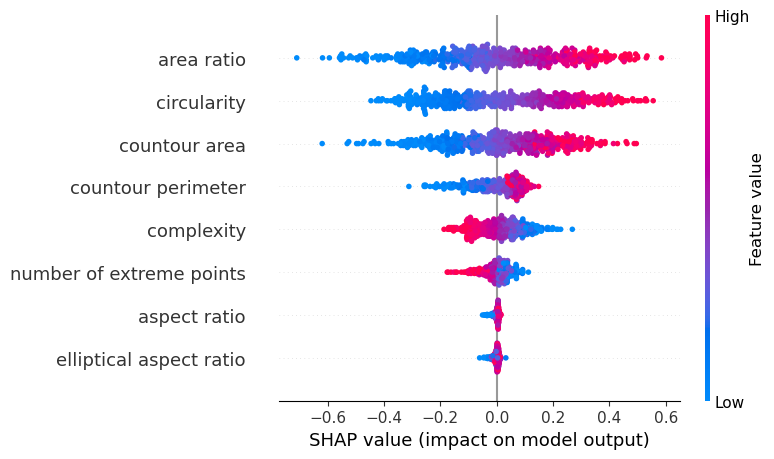

/tmp/tmp.n4xzEQjfB8/ipykernel_3438932/3760137308.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1],


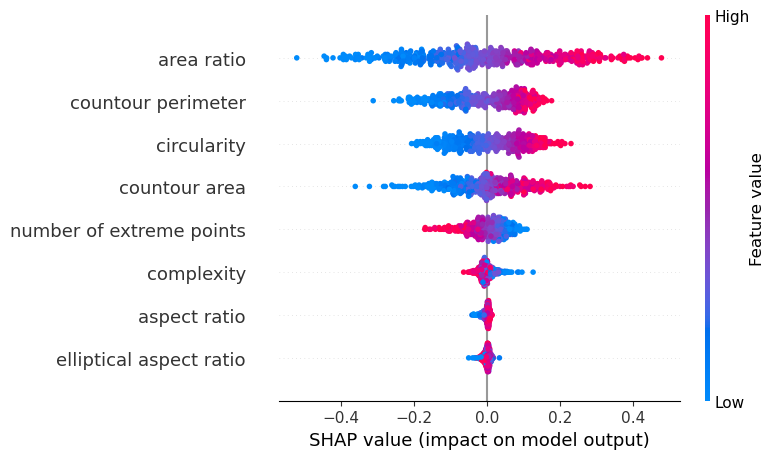

In [25]:
feature_labels = ['aspect ratio',
'elliptical aspect ratio',
'number of extreme points', 
'countour area',
'countour perimeter',
'area ratio',
'complexity',
'circularity']
save_dir = '/home/jko/ice3d/output/figs/shap'

# For output rho_eff:
shap.summary_plot(shap_values[:, :, 0],
test_samples.cpu().numpy(),
feature_names=feature_labels,
show=False
)
filename = 'shap_summary_rho_eff.png'
filepath = os.path.join(save_dir, filename)
plt.savefig(filepath, dpi=150, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to avoid overlap

# For output sa_eff:
shap.summary_plot(shap_values[:, :, 1], 
test_samples.cpu().numpy(),
feature_names=feature_labels,
show=False
)
filename = 'shap_summary_sa_eff.png'
filepath = os.path.join(save_dir, filename)
plt.savefig(filepath, dpi=150, bbox_inches='tight')
plt.show()
plt.close()

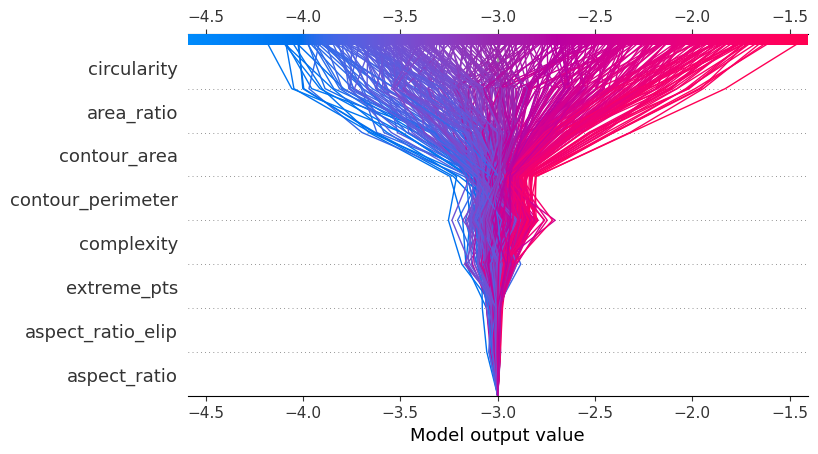

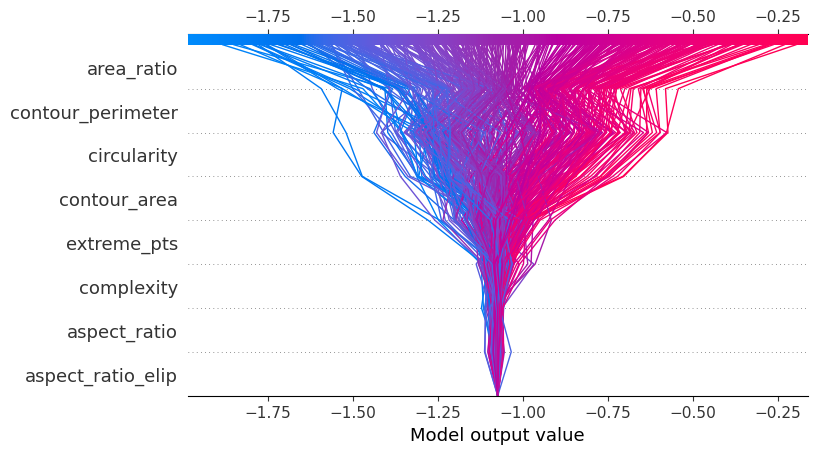

In [37]:
with torch.no_grad():
    expected_value = model(background).mean(dim=0).cpu().numpy()

shap.decision_plot(
    expected_value[0],           # For output 0 (rho_eff)
    shap_values[:, :, 0],                  # SHAP values for output 0, shape (n_samples, n_features)
    test_samples.cpu().numpy(),
    feature_names=features
)

shap.decision_plot(
    expected_value[1],           # For output 1 (sa_eff)
    shap_values[:, :, 1],                  # SHAP values for output 1
    test_samples.cpu().numpy(),
    feature_names=features
)

# SHAP for Classification

In [2]:
# tabular
tab_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
tab_file = 'ros-tabular-data-shuffled-default-subset-700000.parquet'
tab_path = os.path.join(tab_dir, tab_file)
tab_stereo_2ds_file = 'ros-tabular-data-stereo-default-2ds-shuffled-subset-700000.parquet'
tab_stereo_2ds_path = os.path.join(tab_dir, tab_stereo_2ds_file)
tab_stereo_phips_file = 'ros-tabular-data-stereo-default-phips-shuffled-subset-700000.parquet'
tab_stereo_phips_path = os.path.join(tab_dir, tab_stereo_phips_file)
# Load the class mapping from a JSON file
class_mapping_file = '/home/jko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

In [3]:
features = ['aspect_ratio', 'aspect_ratio_elip', 
'extreme_pts', 'contour_area', 'contour_perimeter', 
'area_ratio', 'complexity', 'circularity']
targets = ['n_arms']
batch_size = 128
n_rand = 666
num_workers = 16
def log_transform(x):
    return torch.log(x)
split = [0.7, 0.15, 0.15]
n_data = 700_000
assert abs(sum(split) - 1.0) < 1e-8, "Split does not sum to 1"
n_train = int(split[0] * n_data)
n_val = int(split[1] * n_data)
n_test = n_data - n_train - n_val  # ensures all data is used
train_idx = list(range(0, n_train))
val_idx = list(range(n_train, n_train + n_val))
test_idx = list(range(n_train + n_val, n_data))

In [4]:
def get_transforms(data_type, input_channels, task_type):
    transforms = {}
    # Define transforms based on data_type
    if data_type in ['single_view_h5', 'stereo_view_h5']:
        train_transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        val_transform = T.Compose([
                T.Normalize(mean=[0.5] * input_channels, std=[1.0] * input_channels)
            ])
        transforms['train'] = train_transform
        transforms['val'] = val_transform
        transforms['test'] = val_transform
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['train_target'] = target_transform
        transforms['val_target'] = target_transform
        transforms['test_target'] = target_transform    
        return transforms
    elif data_type == 'tabular':
        # define target transform
        if task_type == 'classification':
            target_transform = None
        else:
            def log_transform(x):
                return torch.log(x)
            target_transform = log_transform
        transforms['target'] = target_transform
        return transforms
    else:
        return None

# user parameters        
data_type = 'tabular'
input_channels = 2
task_type = 'classification'
transforms = get_transforms(data_type, input_channels, task_type)

In [5]:
# set up tabular data module
dm = TabularDataModule(
    data_file=tab_path,
    feature_names=features,
    target_names=targets,
    batch_size=batch_size,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=num_workers,
    task_type='classification',
    class_to_idx=class_to_idx,
    target_transform=None,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()

In [6]:
model_ckpt = '/home/jko/ice3d/models/lightning_logs/mlp-classification-subset-700k-csv/version_2/checkpoints/model-epoch=41-val_loss=1.1785.ckpt'
model = MLPClassification.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    input_size=8, 
    num_classes=7, 
    learning_rate=1e-3
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model.to("cpu")

model.eval()

MLPClassification(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=7, bias=True)
)

In [7]:
# Collect at least N samples (e.g., 250)
loader = dm.test_dataloader()
inputs_list = []
N = 1000
for batch in loader:
    # If batch is (inputs, targets)
    if isinstance(batch, (tuple, list)):
        inputs = batch[0]
    else:
        inputs = batch
    inputs_list.append(inputs)
    if sum(x.shape[0] for x in inputs_list) >= N:
        break

# Concatenate and trim to exactly N samples
all_inputs = torch.cat(inputs_list, dim=0)[:N]

background = all_inputs[:100]
test_samples = all_inputs[100:600]

In [8]:
# Ensure tensors are on the same device as the model
background = background.to(model.device)
test_samples = test_samples.to(model.device)

# explainer = shap.DeepExplainer(model, background)
# NOTE: deepexplainer doesn't work for some reason
explainer = shap.GradientExplainer(model, background)

In [9]:
# compute SHAP values
shap_values = explainer.shap_values(test_samples)

In [10]:
print(type(shap_values))
print(np.shape(shap_values))

<class 'numpy.ndarray'>
(500, 8, 7)


/tmp/tmp.n4xzEQjfB8/ipykernel_3438932/3255577683.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(mean_shap, test_samples_np, feature_names=feature_labels, show=False)


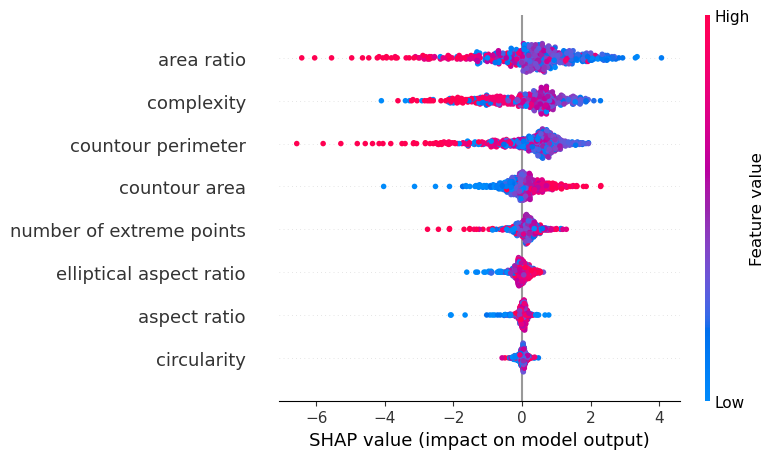

In [14]:
feature_labels = ['aspect ratio',
'elliptical aspect ratio',
'number of extreme points', 
'countour area',
'countour perimeter',
'area ratio',
'complexity',
'circularity']
save_dir = '/home/jko/ice3d/output/figs/shap'

# Assume:
# shap_values: numpy array of shape (n_samples, n_features, n_classes)
# test_samples: numpy array or tensor of shape (n_samples, n_features)

# Transpose to (n_classes, n_samples, n_features)
shap_array = np.transpose(shap_values, (2, 0, 1))  # (n_classes, n_samples, n_features)

# # Take mean absolute SHAP value across classes: (n_samples, n_features)
# mean_abs_shap = np.mean(np.abs(shap_array), axis=0)  # (n_samples, n_features)

# Take mean SHAP value across classes: (n_samples, n_features)
mean_shap = np.mean(shap_array, axis=0)  # (n_samples, n_features)

# Ensure test_samples is a numpy array
if hasattr(test_samples, "cpu"):
    test_samples_np = test_samples.cpu().numpy()
else:
    test_samples_np = test_samples

# Ensure shapes match
assert mean_shap.shape == test_samples_np.shape, f"Shape mismatch: {mean_abs_shap.shape} vs {test_samples_np.shape}"

# # Option 1: Plot using SHAP's summary_plot (shows global importance)
# shap.summary_plot(mean_abs_shap, test_samples, feature_names=feature_names, plot_type="bar")

# Option 2: Plot as a beeswarm (shows distribution)
shap.summary_plot(mean_shap, test_samples_np, feature_names=feature_labels, show=False)

# save plot
save_dir = '/home/jko/ice3d/output/figs/shap'
filename = 'shap_summary_n_arms.png'
filepath = os.path.join(save_dir, filename)
plt.savefig(filepath, dpi=150, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to avoid overlap